In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np
from sklearn import preprocessing
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib

In [2]:
df = pd.read_csv('ks-projects-201801.csv', encoding = "ISO-8859-1")

In [3]:
print("The given table has the following attributes" + str(list(df)))
# Make sure that all the date times are in the proper format in pandas
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])

# # to unix timestamp
df['deadline']=df['deadline'].astype(np.int64)
df['launched']=df['launched'].astype(np.int64)
df['duration']=df['launched']-df['deadline']

The given table has the following attributes['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']


In [4]:
# Drop the columns that have values giving away the answer or the values that do not give any necessary addage to the model.
df.drop('ID', axis=1,inplace=True)
df.drop('pledged', axis=1,inplace=True)
df.drop('usd pledged', axis=1,inplace=True)
df.drop('goal', axis=1,inplace=True)
df.drop('usd_pledged_real', axis=1,inplace=True)
df.drop('name', axis=1,inplace=True)
df.drop('deadline', axis=1,inplace=True)
df.drop('launched', axis=1,inplace=True)
df.drop('duration', axis=1,inplace=True)

print("The final model will use the following attributes:" + str(list(df)))

print("The given data has the following unique states:" + str(df.state.unique()))
print("Since the states like 'undefined' and 'suspended' and 'cancelled' provide no value to the classification, we shall remove them.")
# Remove the values that may confuse the classifiers among the available states:
df.drop(df[df.state == 'undefined'].index,inplace=True)
df.drop(df[df.state == 'live'].index,inplace=True)
df.drop(df[df.state == 'suspended'].index,inplace=True)


The final model will use the following attributes:['category', 'main_category', 'currency', 'state', 'backers', 'country', 'usd_goal_real']
The given data has the following unique states:['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']
Since the states like 'undefined' and 'suspended' and 'cancelled' provide no value to the classification, we shall remove them.


In [5]:
# Converting non-numeric values to numeric ones:
le=preprocessing.LabelEncoder()
le.fit(df.category)
df.category=le.transform(df.category) 
# to see the corresponding names
#list(le.inverse_transform(le.transform(df.category.unique()) ))

le.fit(df.main_category)
df.main_category=le.transform(df.main_category) 

le.fit(df.currency)
df.currency=le.transform(df.currency)

le.fit(df.country)
df.country=le.transform(df.country)

df['state'] = df['state'].map({'failed' : 0,'canceled' : 0,'successful' : 1})

,category,main_category,currency,state,backers,country,usd_goal_real
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False


In [37]:
df_new=df[:10000]

In [38]:
y = df_new.state
X = df_new.drop('state', axis=1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=102)
 
# 5. Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                          RandomForestRegressor(n_estimators=10))
 
# # 6. Declare hyperparameters to tune
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}
 
# #7. Tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
 
clf.fit(X_train, y_train)
 
# # 8. Refit on the entire training set

# # No additional code needed if clf.refit == True (default is True)
 
# # 9. Evaluate model pipeline on test data
y_pred = np.around(clf.predict(X_test))

r2_random_forest = r2_score(y_test, y_pred)
mse_random_forest = mean_squared_error(y_test, y_pred)

print(r2_random_forest)
print(mse_random_forest)

0.6922129886118805
0.071


Text(0,0.5,'Predicted values')

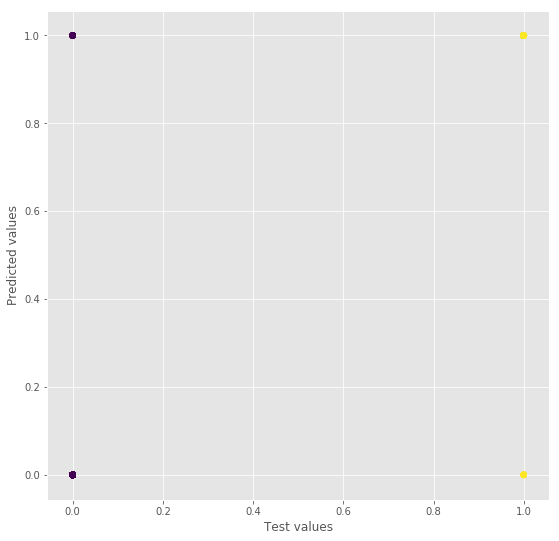

In [31]:
plt.figure(figsize=(9,9))
plt.scatter(y_test.tolist(),y_pred, c=y_test)
plt.xlabel("Test values")
plt.ylabel("Predicted values")

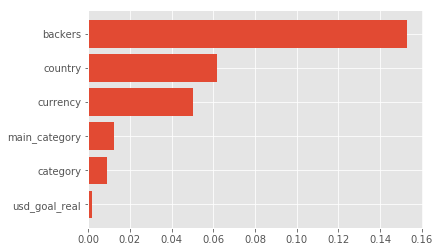

0.542654511247231
0.1055


In [41]:
#Learning feature importance of linear SVM kernel, because non-linear is not possible. And since the SVC is giving an accuracy 
#of 100%, which seems absurd. 
# svc = SVC()
# svc.fit(X_train, y_train)
# y_pred = svc.predict(X_test)
# acc_svc = round(svc.score(X_train, y_train) * 100, 2)

# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)
# acc_log = round(logreg.score(X_train, y_train) * 100, 2)
# acc_log

#Learning feature importance of linear SVM kernel, because non-linear is not possible. ANd since the SVC is giving an accuracy 
#of 100%, which seems absurd.
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)

acc_linear_svc = round(linear_svc.score(X_test, y_test) * 100, 2)
acc_linear_svc

def f_importances(coef, names):
    imp = abs(coef[0])
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = list(X)
svm = LinearSVC()
svm.fit(X_test,y_test)
f_importances(svm.coef_, features_names)
y_pred=svm.predict(X_test)

print(r2_score(y_test, y_pred))

print(mean_squared_error(y_test, y_pred))

In [12]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)

acc_linear_svc = round(linear_svc.score(X_test, y_test) * 100, 2)
acc_linear_svc

50.0

In [29]:
np.shape(svm.coef_)
# np.shape(list(X))

(3, 7)

In [139]:
r2_score(y_test, y_pred)

-0.25

In [10]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [14]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

52.38

In [32]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)

print(r2_score(y_test, Y_pred))

print(mean_squared_error(y_test, Y_pred))

-0.7079674069101827
2.29


In [33]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)



print(r2_score(y_test, Y_pred))

print(mean_squared_error(y_test, Y_pred))

-0.6520296097406353
2.215
